# (13) Fit -- cuda

**Motivation**: Fitting notebook, cuda (```gaban```) <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

## Trainer

In [3]:
vae = VAE(ConfigVAE(
    'fixate1', n_enc_cells=1, n_dec_cells=1, n_enc_nodes=3, n_dec_nodes=2,              
    n_latent_scales=3, n_groups_per_scale=12, n_latent_per_group=13, save=True,
))
tr = TrainerVAE(
    model=vae,
    cfg=ConfigTrainVAE(
        lr=0.002, batch_size=1000, epochs=400, grad_clip=1000,
        warm_restart=1, warmup_portion=0.025,
        lambda_anneal=True, lambda_init=1e-7, lambda_norm=1e-4, 
        kl_beta=0.20, kl_anneal_cycles=1, kl_anneal_portion=0.3, kl_const_portion=1e-4),
    device='cuda',
)
vae.cfg.total_latents()

273

In [16]:
sum(vae.ftr_sizes()[0].values())

2752

In [3]:
vae.print()
vae.scales

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  21.3 Mil  |
|     ---      |    ---     |
|     stem     |    320     |
| pre_process  |  151.6 K   |
|  enc_tower   |  11.5 Mil  |
|     enc0     |   66.0 K   |
| enc_sampler  |  1.7 Mil   |
| dec_sampler  |  1.6 Mil   |
|    expand    |  148.6 K   |
|  dec_tower   |  6.0 Mil   |
| post_process |   67.9 K   |
|     out      |    578     |
+--------------+------------+

[8, 4, 2]

In [4]:
len(vae.all_conv_layers), len(vae.all_log_norm)

(207, 159)

## Review train options

In [5]:
print({
    k: v for k, v in vars(vae.cfg).items() if
    all(e not in k for e in ['useful', 'dir', 'path', 'file'])
})

{
    'sim': 'fixate1',
    'n_ch': 32,
    'ker_sz': 2,
    'input_sz': 17,
    'n_enc_cells': 1,
    'n_enc_nodes': 3,
    'n_dec_cells': 1,
    'n_dec_nodes': 2,
    'n_pre_cells': 3,
    'n_pre_blocks': 1,
    'n_post_cells': 3,
    'n_post_blocks': 1,
    'n_latent_scales': 3,
    'n_latent_per_group': 13,
    'n_groups_per_scale': 12,
    'spectral_norm': 0,
    'separable': False,
    'compress': True,
    'use_bn': False,
    'groups': [12, 6, 3],
    'seed': 0,
    'balanced_recon': True,
    'activation_fn': 'swish',
    'residual_kl': True,
    'scale_init': False,
    'ada_groups': True,
    'use_se': True
}

In [6]:
print(vars(tr.cfg))

{
    'lr': 0.002,
    'epochs': 400,
    'batch_size': 1000,
    'warm_restart': 1,
    'warmup_portion': 0.025,
    'optimizer': 'adamax_fast',
    'optimizer_kws': {'betas': (0.9, 0.999), 'weight_decay': 0.0003, 'eps': 1e-08},
    'scheduler_type': 'cosine',
    'scheduler_kws': {'T_max': 130.0, 'eta_min': 1e-05},
    'ema_rate': 0.999,
    'grad_clip': 1000,
    'chkpt_freq': 20,
    'eval_freq': 5,
    'log_freq': 10,
    'use_amp': False,
    'kl_beta': 0.2,
    'kl_beta_min': 0.0001,
    'kl_balancer': 'equal',
    'kl_anneal_cycles': 1,
    'kl_anneal_portion': 0.3,
    'kl_const_portion': 0.0001,
    'lambda_anneal': True,
    'lambda_init': 1e-07,
    'lambda_norm': 0.0001,
    'spectral_reg': False
}

In [7]:
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

fixate1_k-32_z-13x[3,6,12]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)
ep400-b1000-lr(0.002)_beta(0.2:1x0.3)_lamb(0.0001)_gr(1000)

## Train

In [8]:
# comment = f"..._{tr.cfg.name()}"
tr.train(comment=tr.cfg.name())

epoch # 400, avg loss: 8.919611: 100%|████| 400/400 [54:24:43<00:00, 489.71s/it]


## Eval

In [9]:
%%time

val, loss = tr.validate(use_ema=False)
val_ema, loss_ema = tr.validate(use_ema=True)

CPU times: user 1min 54s, sys: 27.8 s, total: 2min 22s
Wall time: 5min 33s


In [10]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(f"{vae.cfg.name()}\n{tr.cfg.name()}\n\n{loss_summary}\n")

fixate1_k-32_z-13x[3,6,12]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)
ep400-b1000-lr(0.002)_beta(0.2:1x0.3)_lamb(0.0001)_gr(1000)

{'epe': {'vae': 2.34, 'ema': 2.34}, 'kl': {'vae': 33.39, 'ema': 33.4}}

fig/sample (VAE)

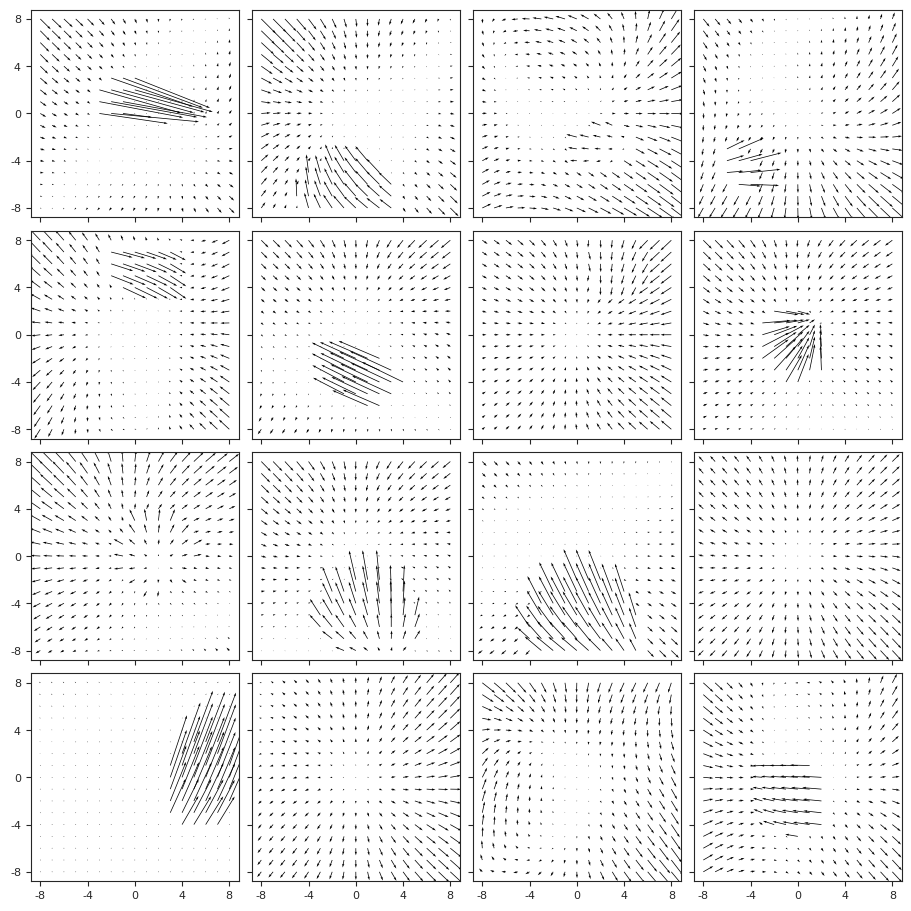

fig/sample (EMA)

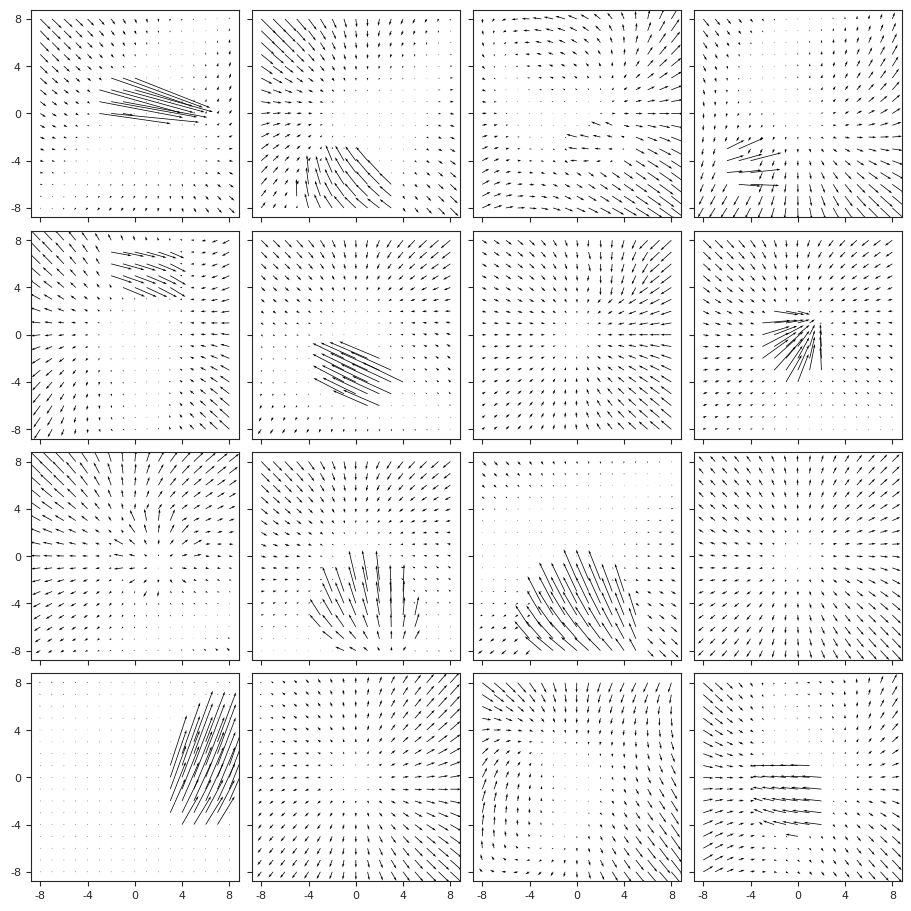

----------------------------------------------------------------------

fig/regression (VAE)

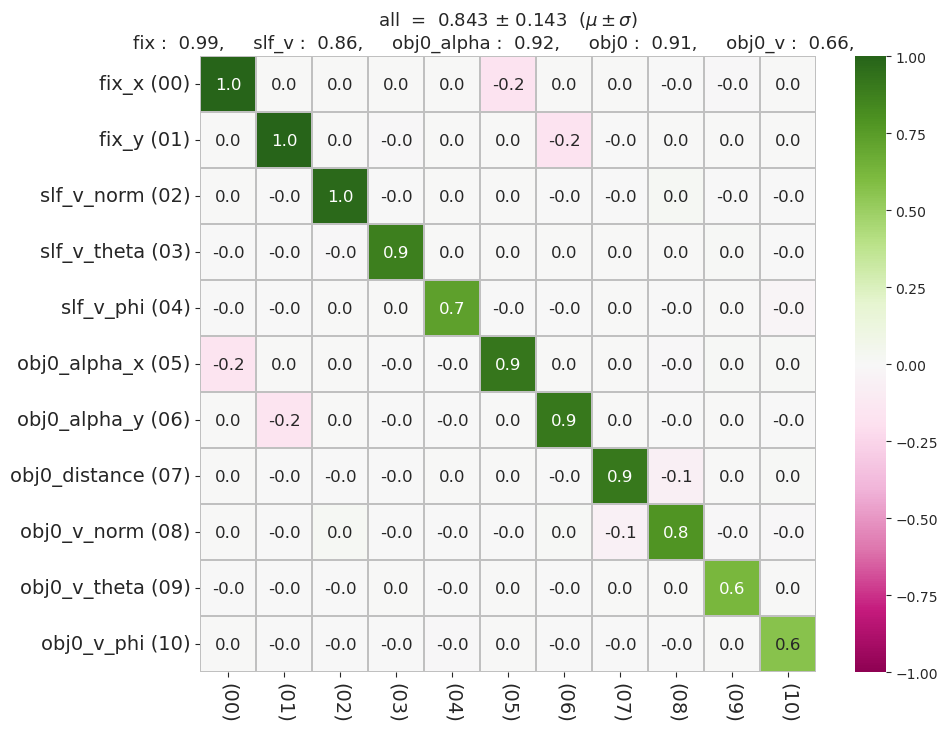

fig/regression (EMA)

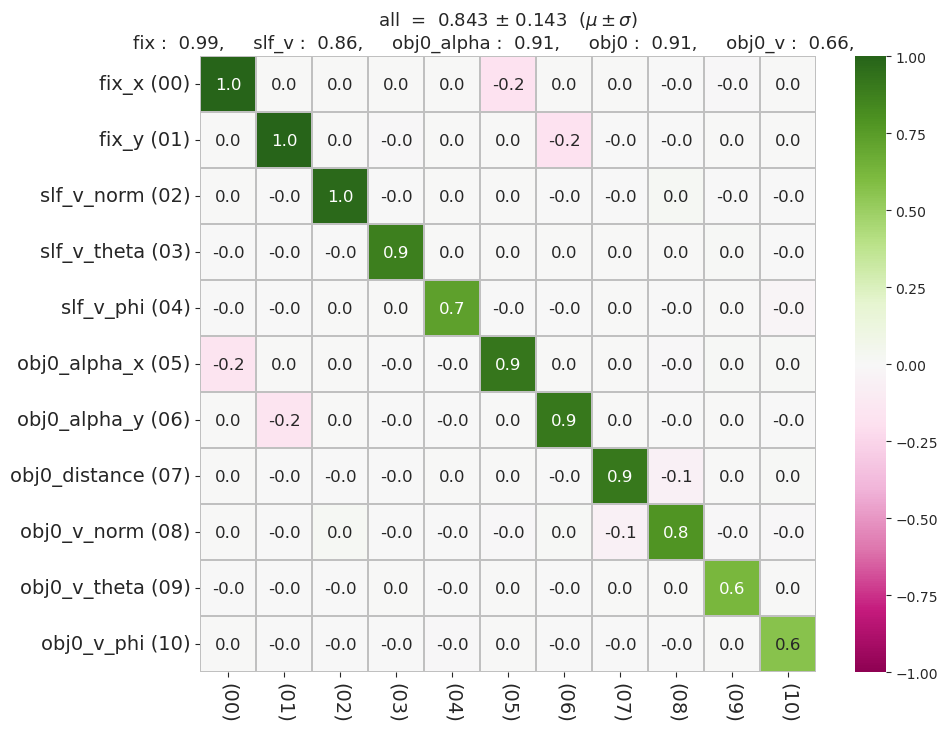

----------------------------------------------------------------------

fig/bar (VAE)

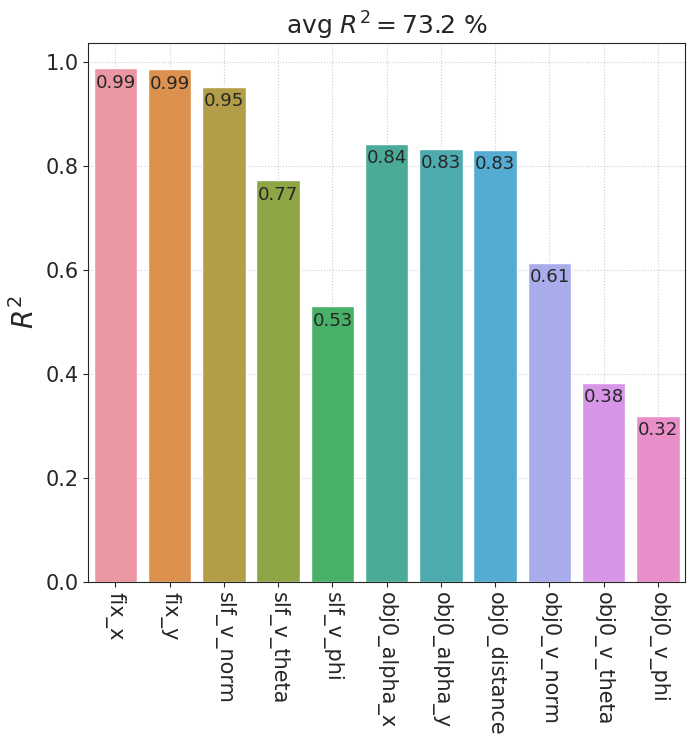

fig/bar (EMA)

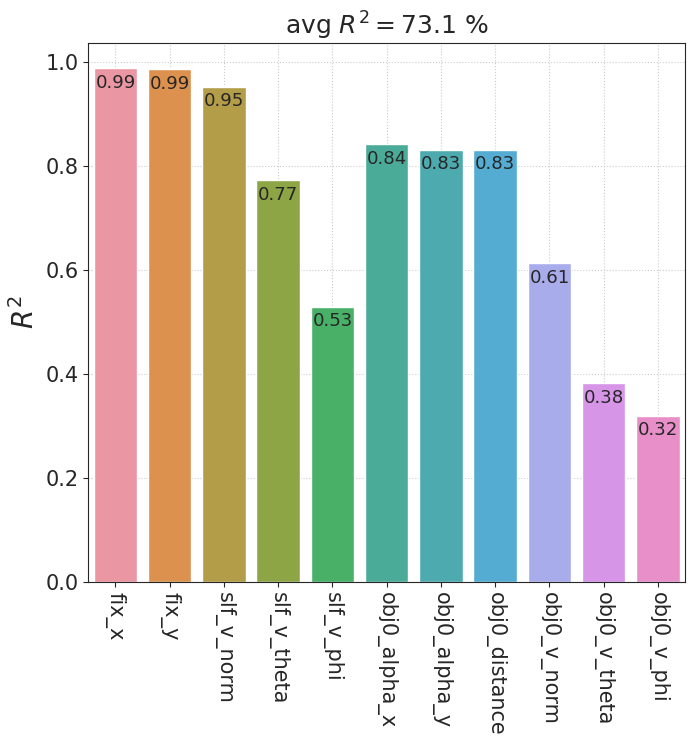

----------------------------------------------------------------------

fig/bar_aux (VAE)

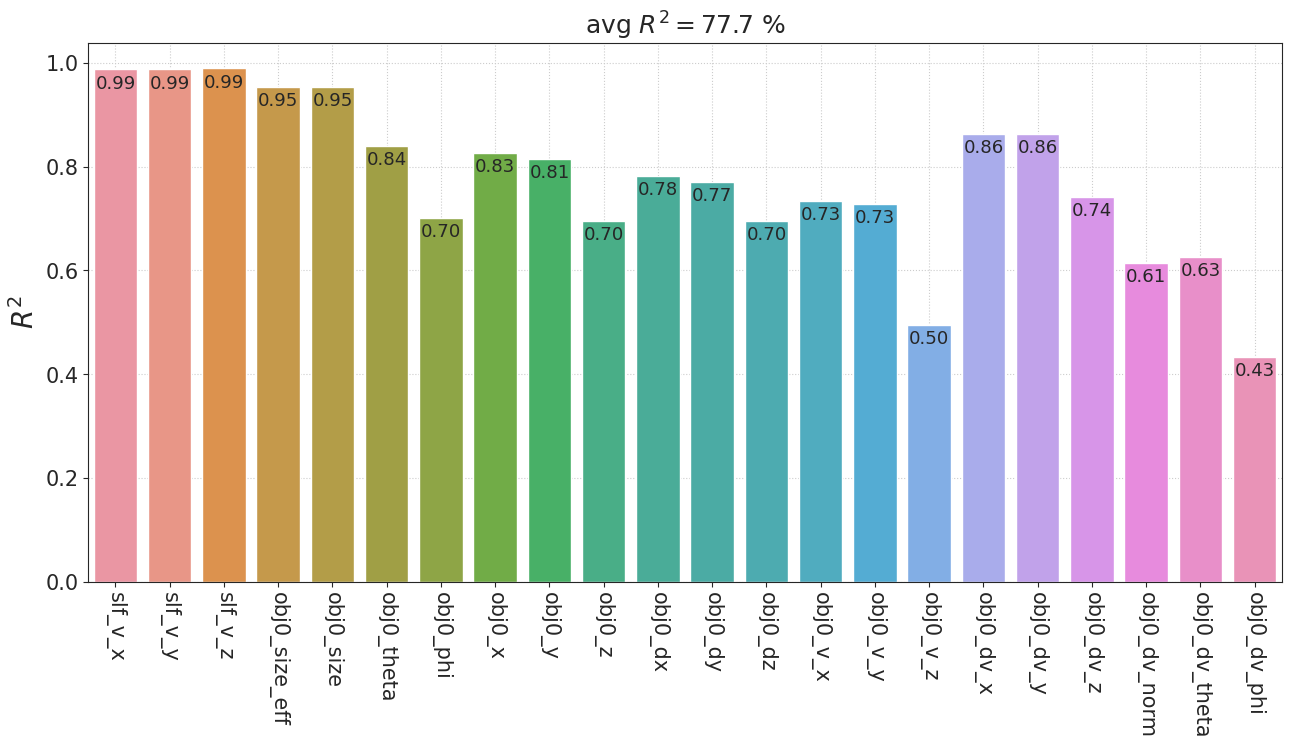

fig/bar_aux (EMA)

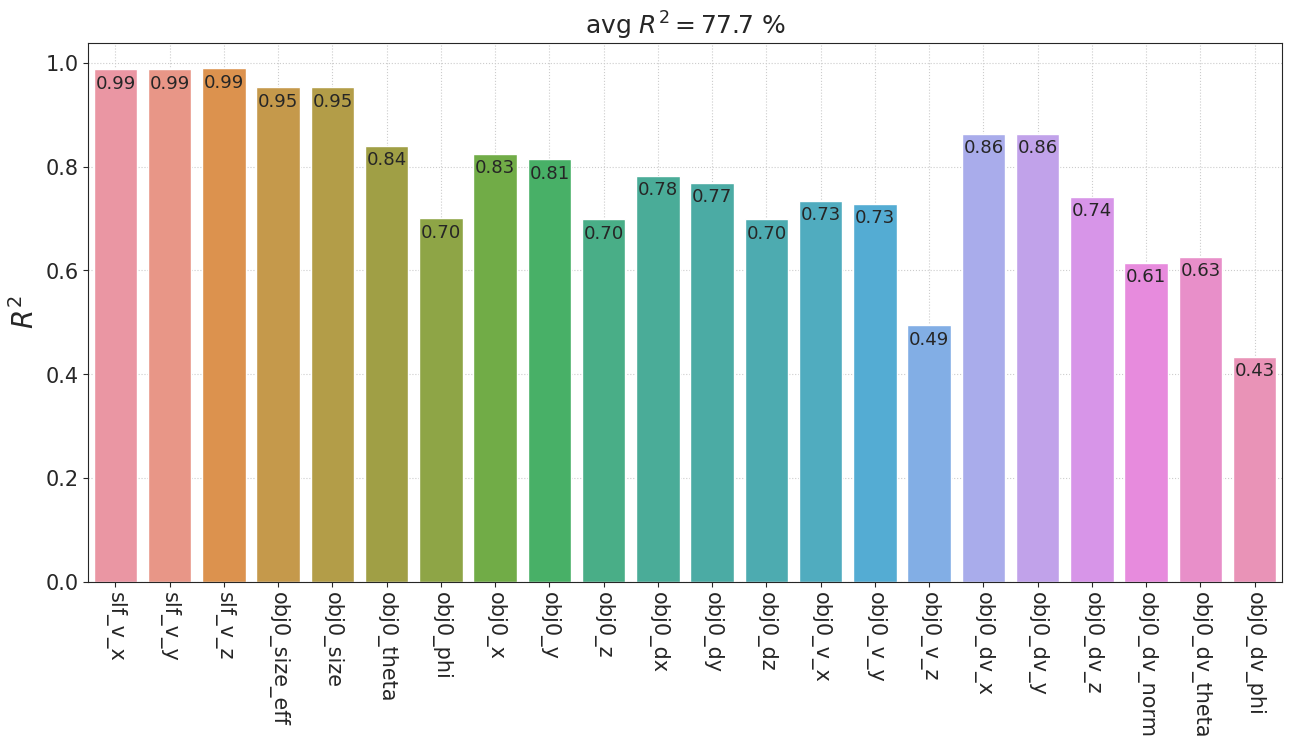

----------------------------------------------------------------------

fig/mutual_info (VAE)

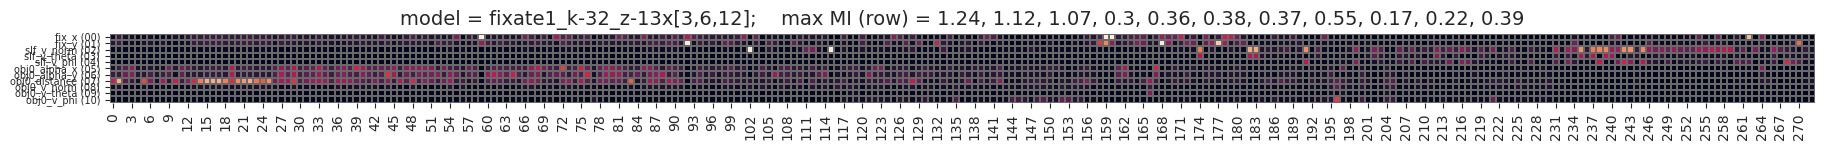

fig/mutual_info (EMA)

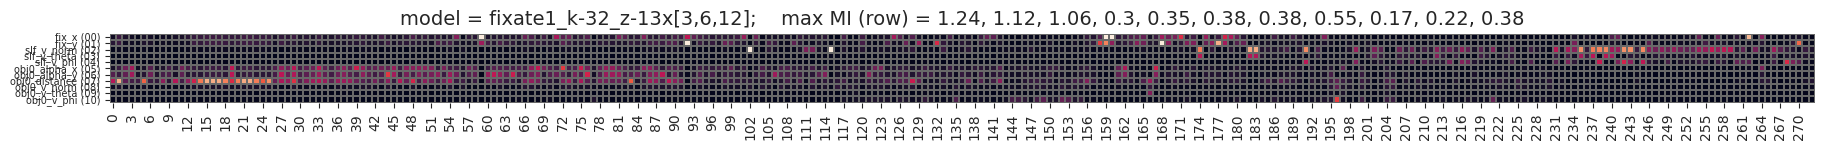

----------------------------------------------------------------------

In [11]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

In [12]:
len(tr.stats['grad'])

148

In [15]:
np.quantile(list(tr.stats['grad'].values()), [0.5, 0.7, 0.9, 1])

array([5.07322217e+03, 1.33244140e+05, 2.09492699e+08, 5.26388019e+10])

In [17]:
np.quantile(list(tr.stats['loss'].values()), [0.5, 0.7, 0.9, 1])

array([1.00411634e+01, 1.93782291e+01, 2.68291146e+04, 9.56360960e+07])

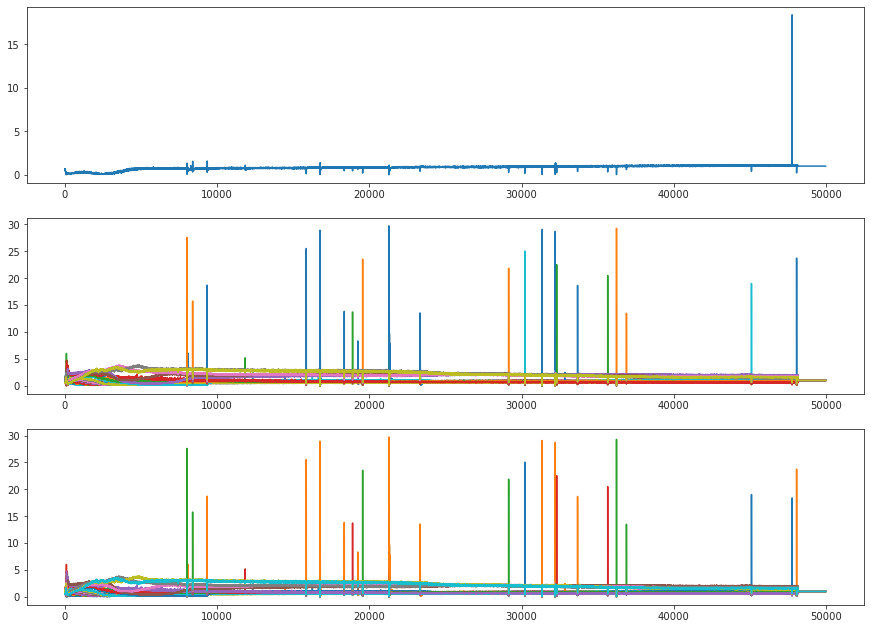

In [17]:
fig, axes = create_figure(3, 1, (15, 11))
axes[0].plot(gamma[:50000, 0])
axes[1].plot(gamma[:50000, 1:])
axes[2].plot(gamma[:50000]);

## DCI

In [30]:
val_ema['regr/r2'], val_ema['regr/r2'].mean(), np.diag(val_ema['regr/r']).mean()

(array([0.98787209, 0.98606033, 0.95231735, 0.77244376, 0.52869628,
        0.84190284, 0.83143266, 0.83057672, 0.612863  , 0.3815909 ,
        0.31850108]),
 0.7312960918564673,
 0.8431506020932581)

In [33]:
do_zscore = False
if do_zscore:
    x = sp_stats.zscore(val_ema['z_vld'])
    y = sp_stats.zscore(tr.dl_vld.dataset.g)
    x_tst = sp_stats.zscore(val_ema['z_tst'])
    y_tst = sp_stats.zscore(tr.dl_tst.dataset.g)
else:
    x = val_ema['z_vld']
    y = tr.dl_vld.dataset.g
    x_tst = val_ema['z_tst']
    y_tst = tr.dl_tst.dataset.g

lr = sk_linear.LinearRegression().fit(x, y)
r2_out = sk_metric.r2_score(
    y_true=y_tst,
    y_pred=lr.predict(x_tst),
    multioutput='raw_values',
)
r_out = 1 - sp_dist.cdist(
    XA=y_tst.T,
    XB=lr.predict(x_tst).T,
    metric='correlation',
)
r2_out, r2_out.mean(), np.diag(r_out).mean()

(array([0.9878726 , 0.98605802, 0.95225915, 0.7724239 , 0.5287071 ,
        0.8416592 , 0.83112916, 0.8305795 , 0.6128181 , 0.3814637 ,
        0.3185065 ]),
 0.7312251771670845,
 0.8431088999788942)

In [58]:
x = val_ema['z_vld'].copy()
y = tr.dl_vld.dataset.g.copy()
x_tst = val_ema['z_tst'].copy()
y_tst = tr.dl_tst.dataset.g.copy()

mu, sd = x.mean(), x.std()
x = (x - mu) / sd
x_tst = (x_tst - mu) / sd

In [59]:
lr = sk_linear.LinearRegression().fit(x, y)
r2_out = sk_metric.r2_score(
    y_true=y_tst,
    y_pred=lr.predict(x_tst),
    multioutput='raw_values',
)
r_out = 1 - sp_dist.cdist(
    XA=y_tst.T,
    XB=lr.predict(x_tst).T,
    metric='correlation',
)
r2_out, r2_out.mean(), np.diag(r_out).mean()

(array([0.98787209, 0.98606033, 0.95231735, 0.77244376, 0.52869628,
        0.84190284, 0.83143266, 0.83057672, 0.612863  , 0.3815909 ,
        0.31850108]),
 0.7312960918564673,
 0.8431506020932581)

In [60]:
val_ema['regr/r2'].mean(), val_ema['regr/d'].mean(), val_ema['regr/c'].mean()

(0.7312960918564673, 0.1873543, 0.41861686)

In [61]:
from analysis.linear import compute_dci

In [62]:
w = np.abs(lr.coef_)
w *= x.std(0).reshape(1, -1)
w /= y.std(0).reshape(-1, 1)

compute_dci(w)

(0.1873543, 0.41861686)

In [63]:
x.shape, y.shape

((75000, 273), (75000, 11))

In [65]:
importances = np.zeros((11, 273))

for i in tqdm(range(11)):
    _lr = sk_linear.LinearRegression().fit(x, y[:, i])
    result = sk_inspect.permutation_importance(
        _lr, x_tst, y_tst[:, i], n_repeats=5, random_state=0)
    importances[i] = result.importances_mean

  0%|          | 0/11 [00:00<?, ?it/s]

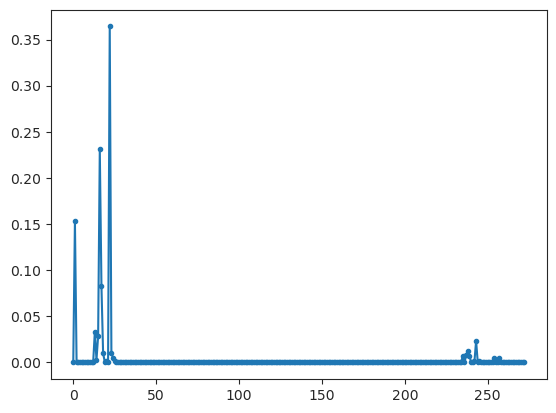

In [66]:
w = np.abs(importances)
rho = w.sum(0) / w.sum()
plt.plot(rho, marker='.')
plt.show()

In [68]:
compute_dci(w)

(0.3747561336550221, 0.7044918165259074)

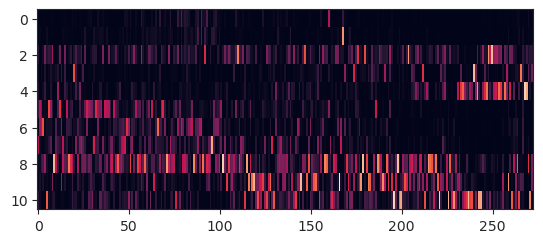

In [71]:
plt.imshow(w / w.sum(0, keepdims=True), aspect=10)

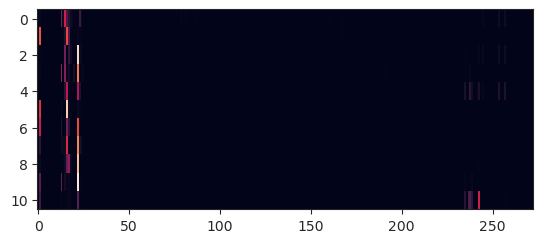

In [72]:
plt.imshow(w / w.sum(1, keepdims=True), aspect=10)

## Imshow Expand

In [74]:
print(vae.expand)

ModuleList(
  (0-2): 3 x DeConv2D(13, 13, kernel_size=(2, 2), stride=(1, 1))
  (3-8): 6 x DeConv2D(13, 13, kernel_size=(4, 4), stride=(1, 1))
  (9-20): 12 x DeConv2D(13, 13, kernel_size=(8, 8), stride=(1, 1))
)

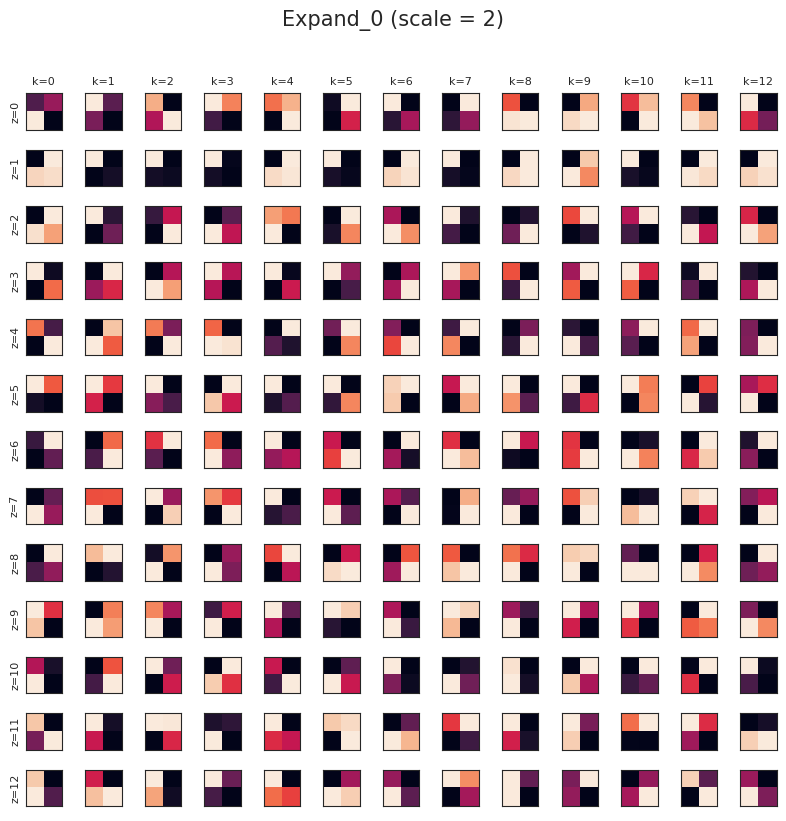

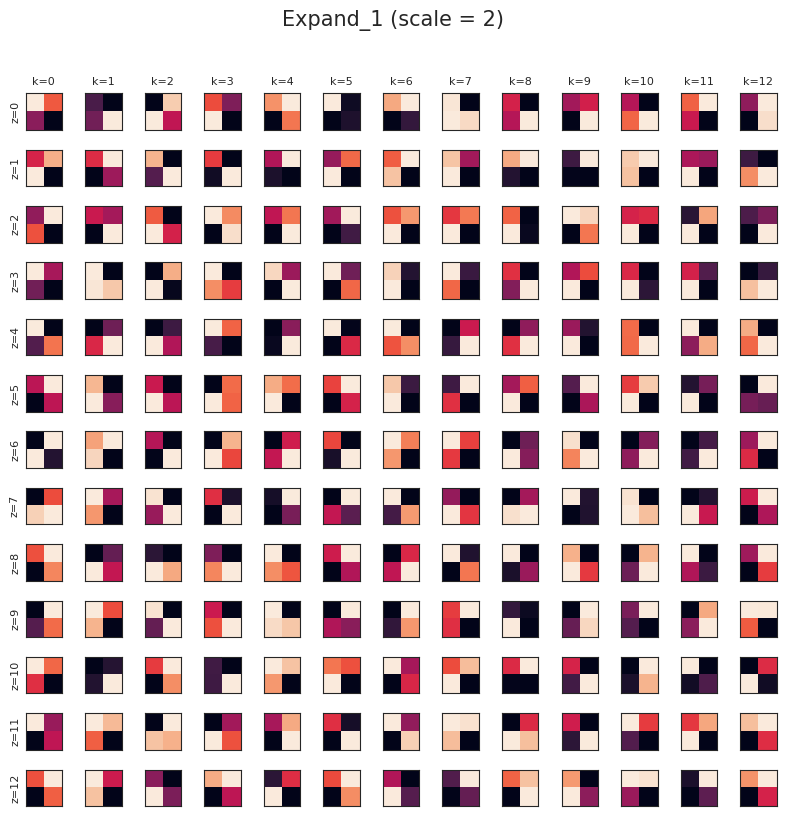

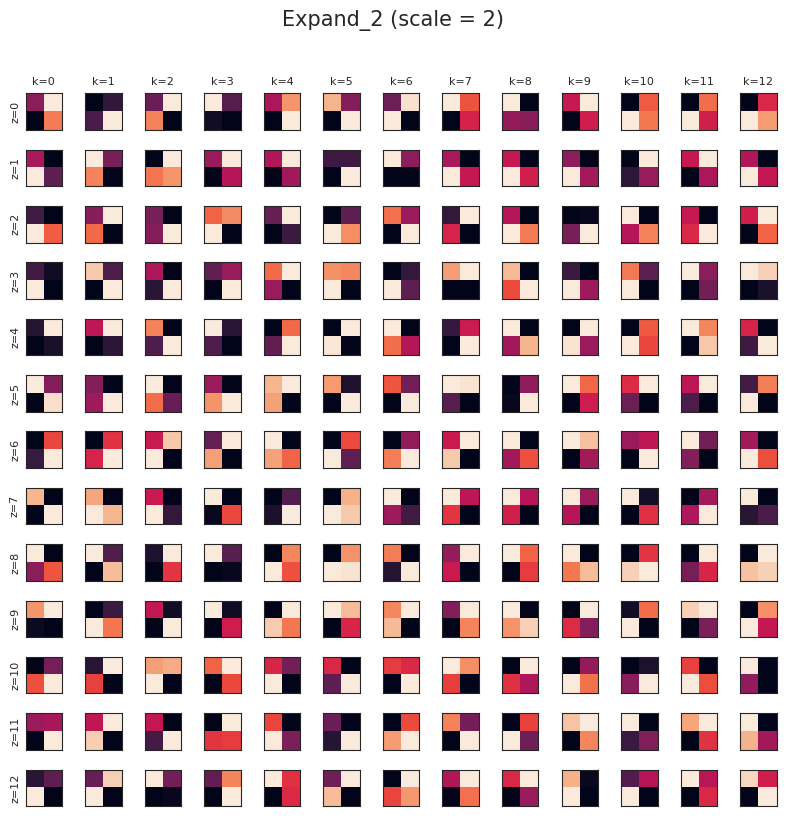

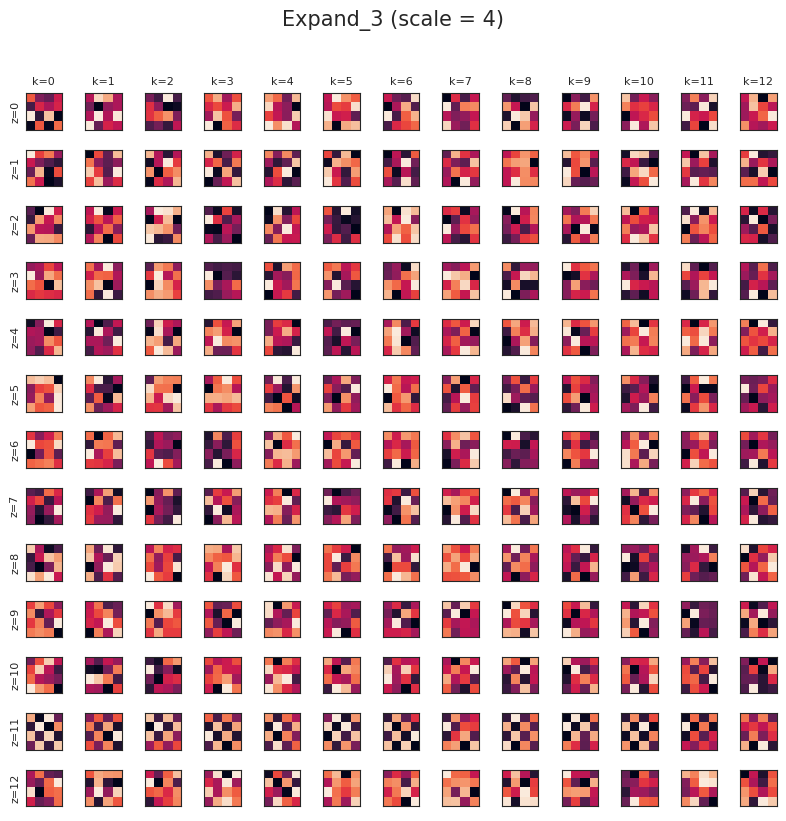

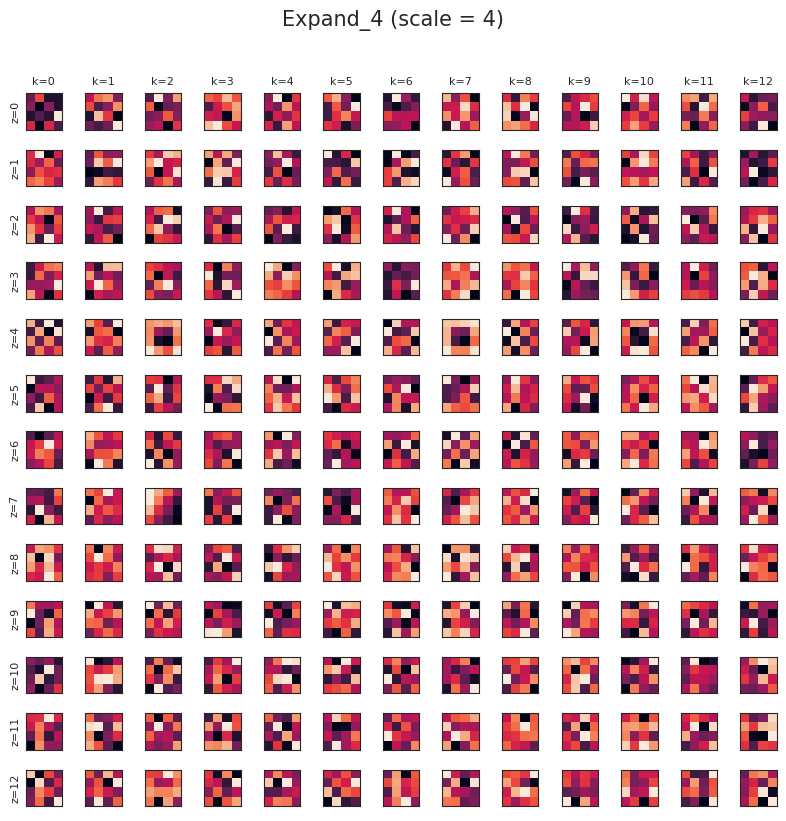

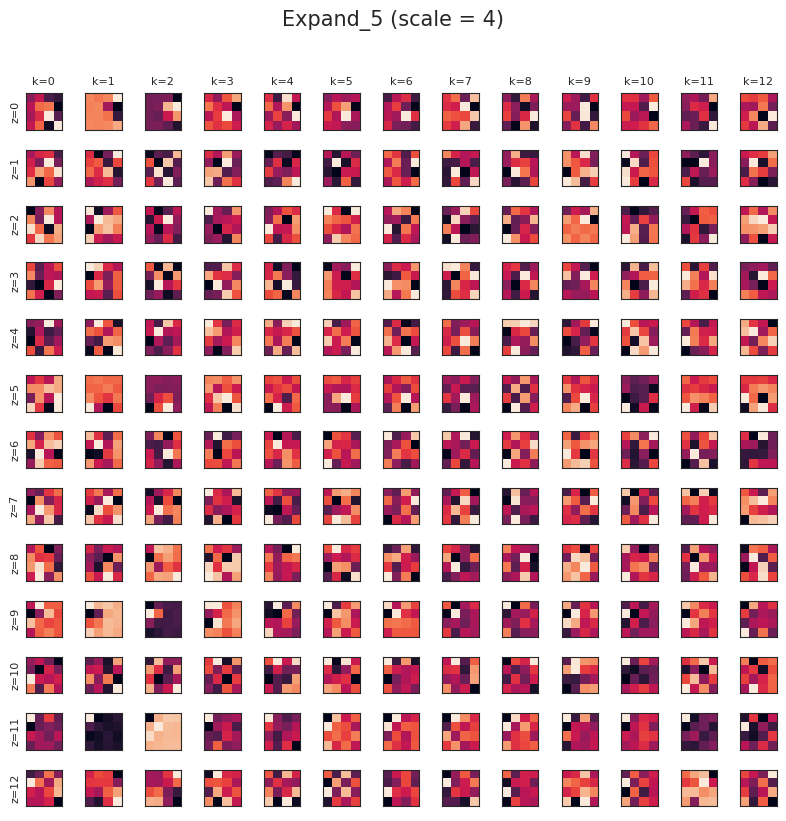

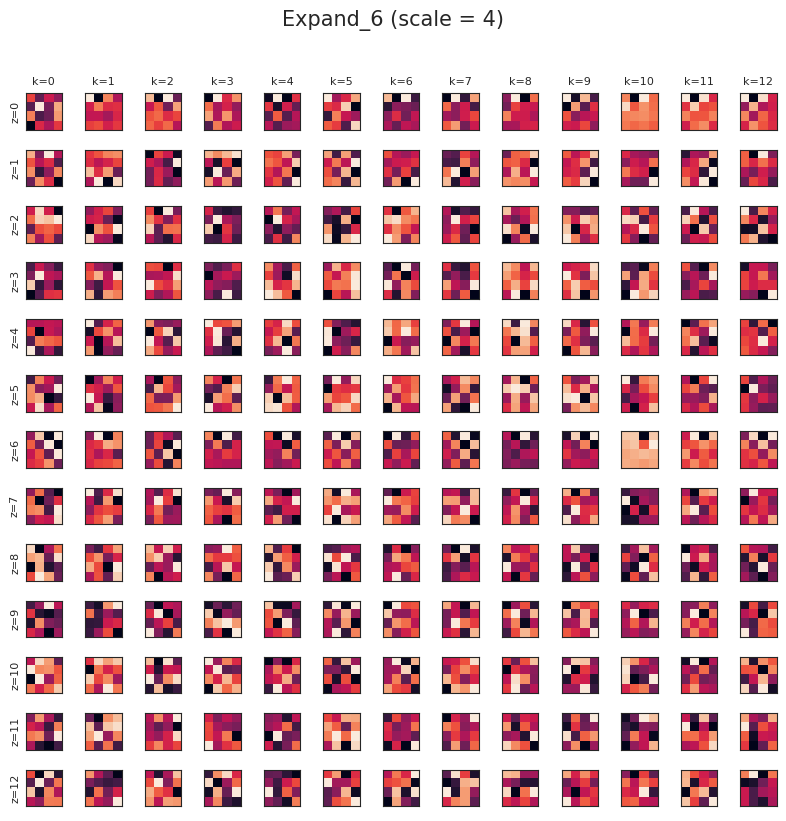

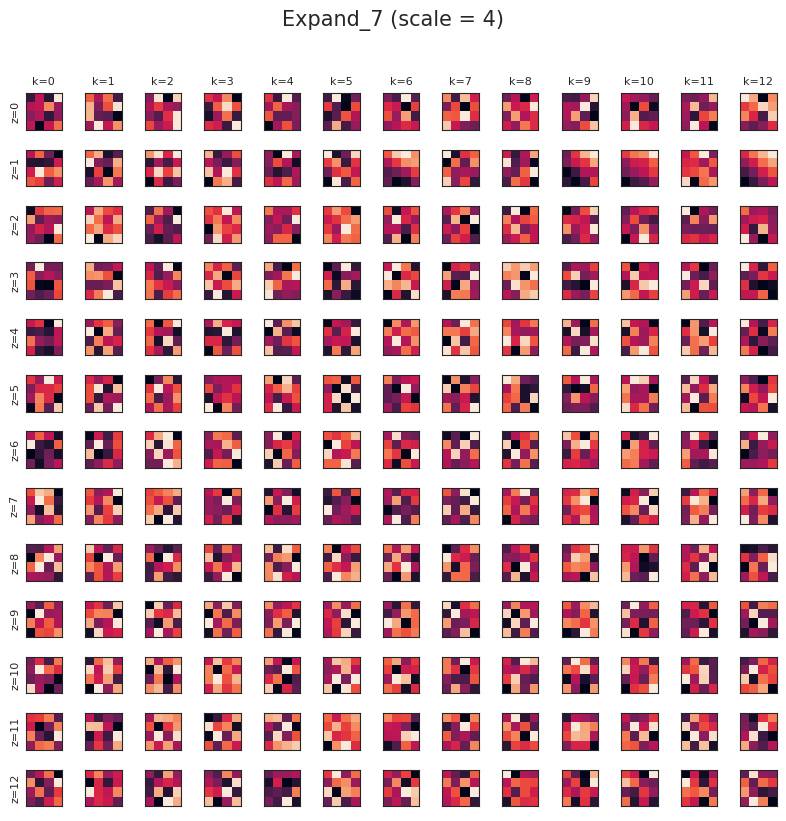

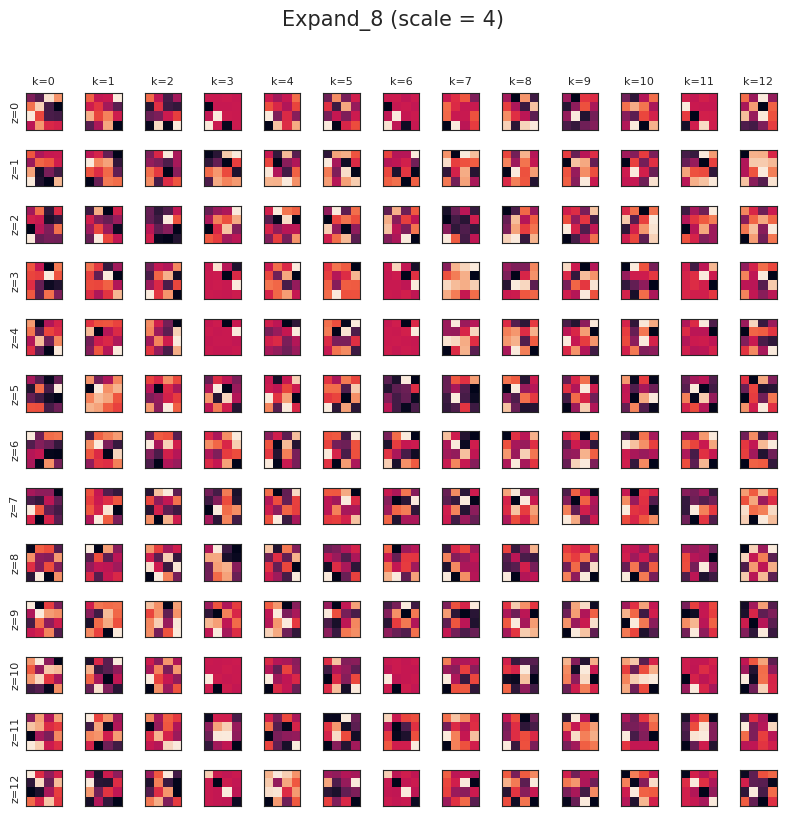

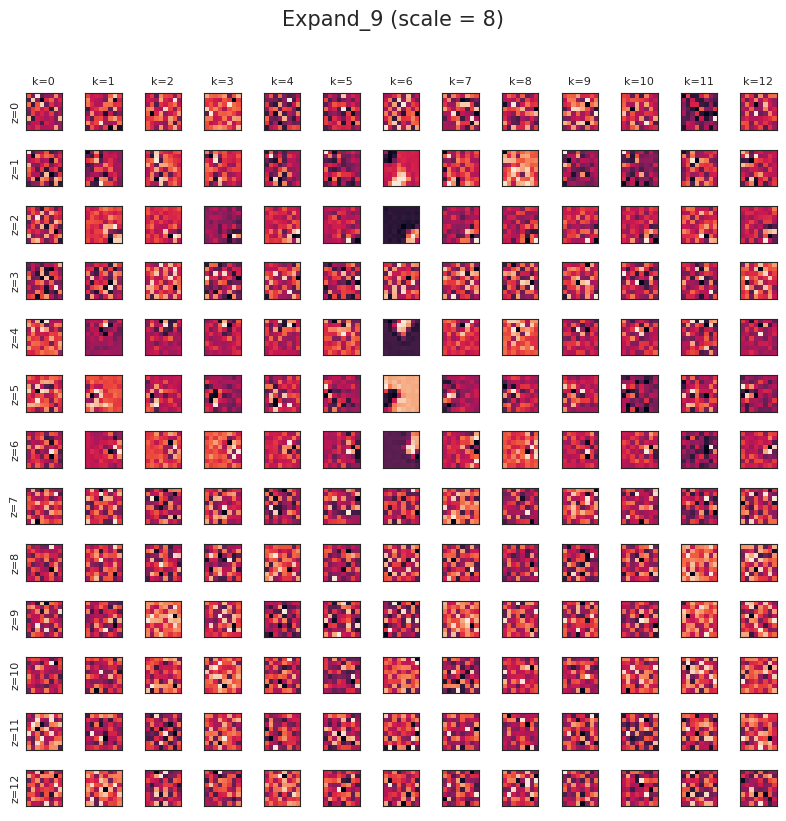

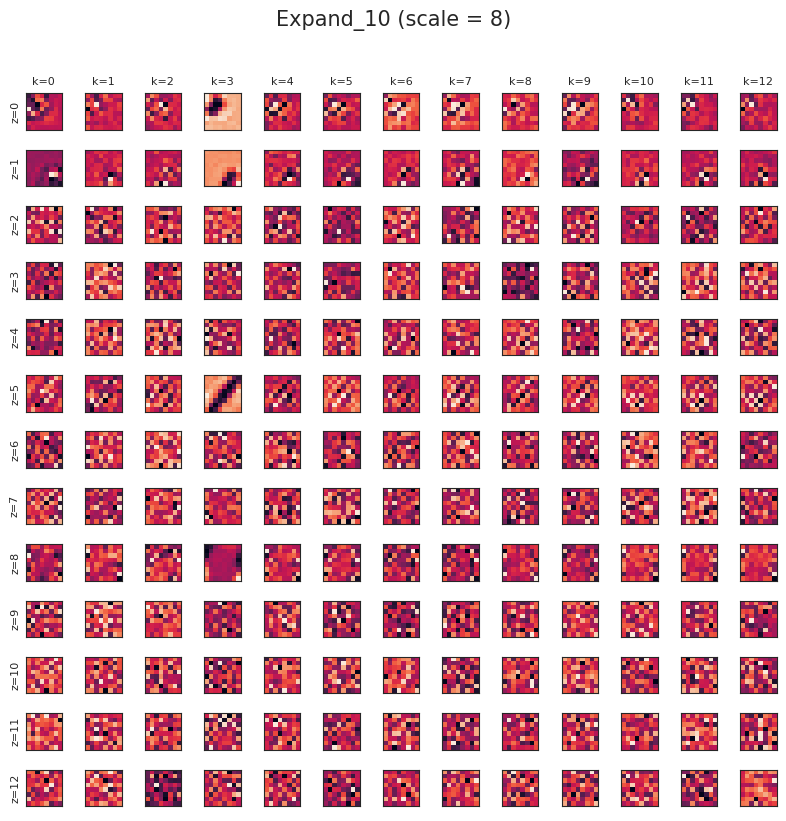

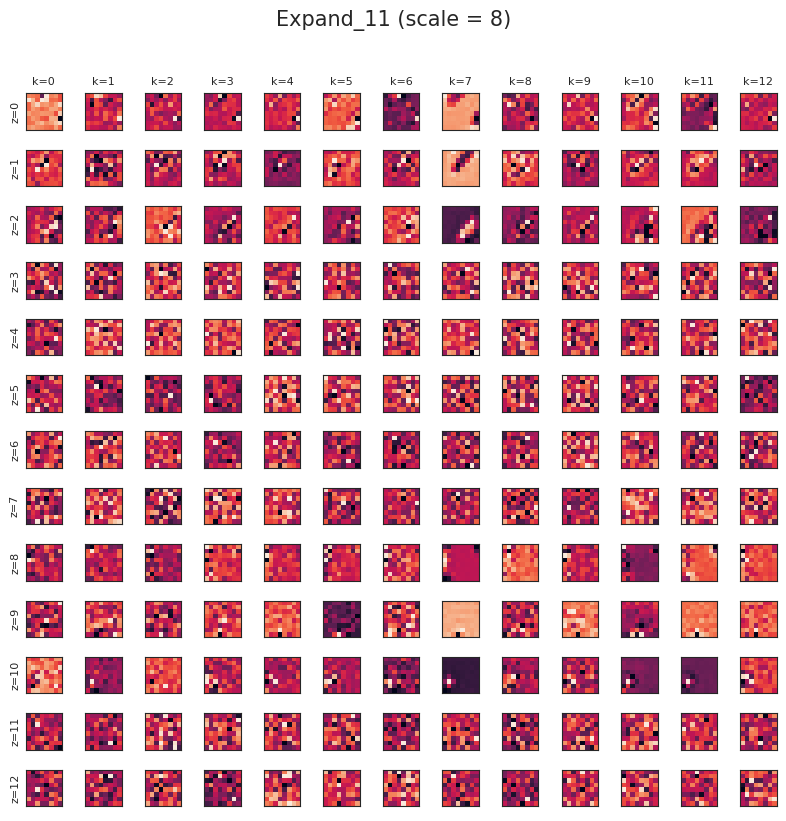

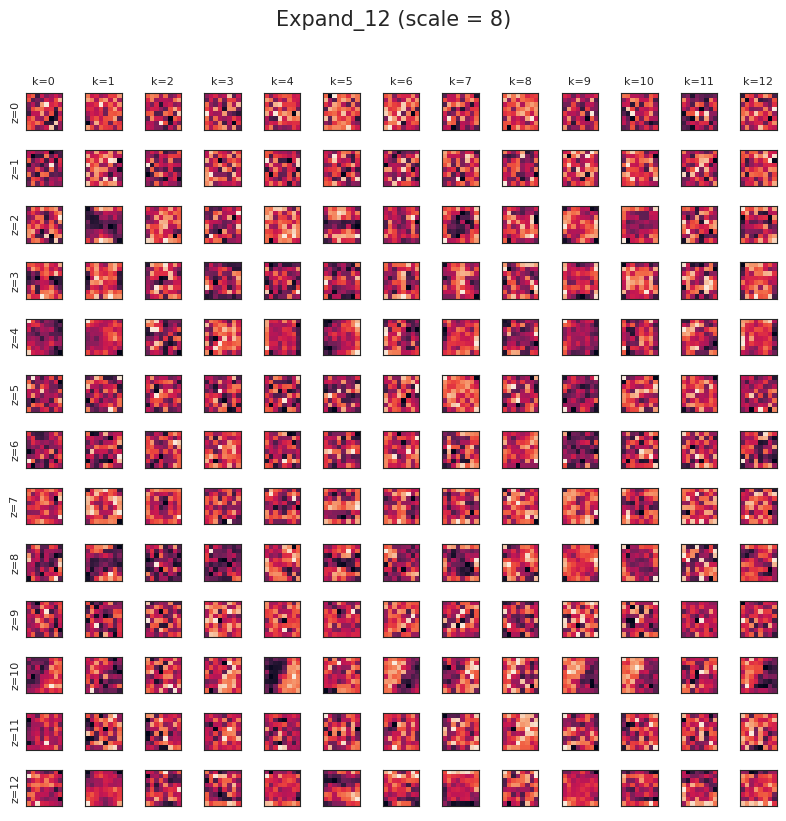

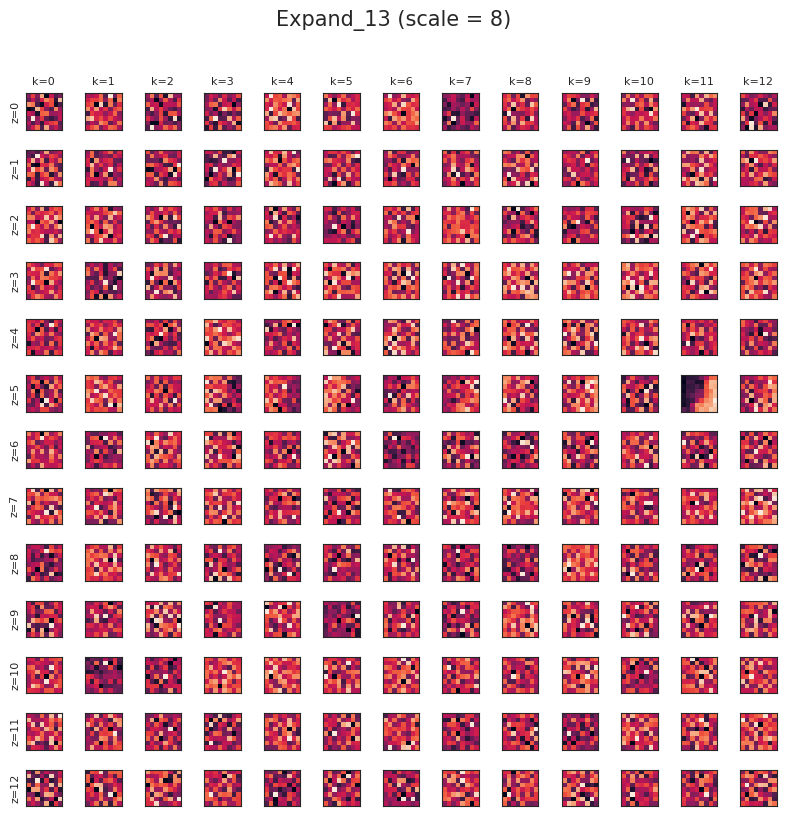

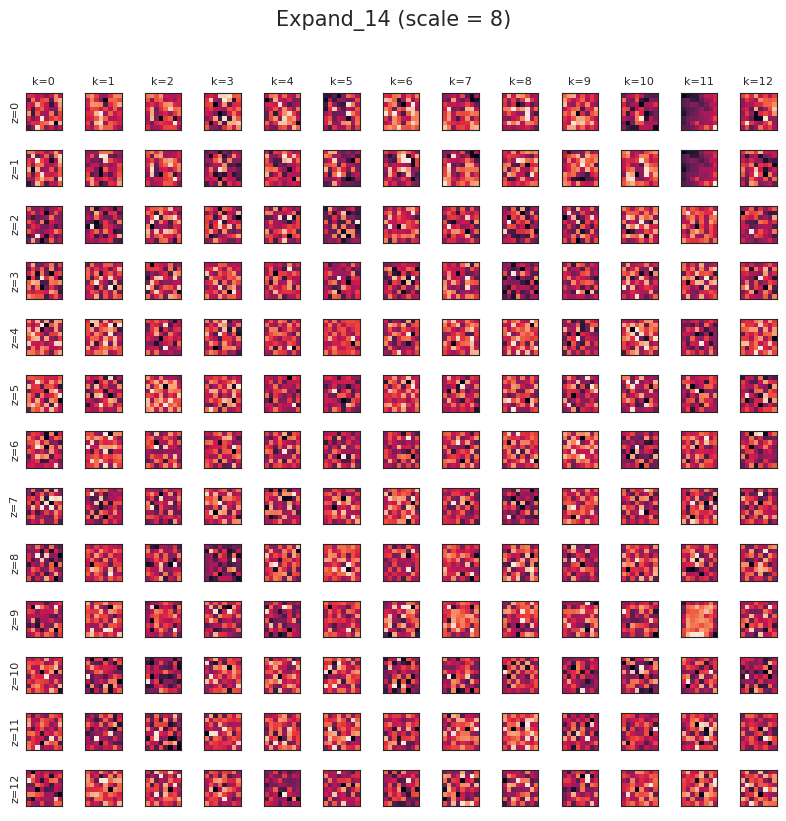

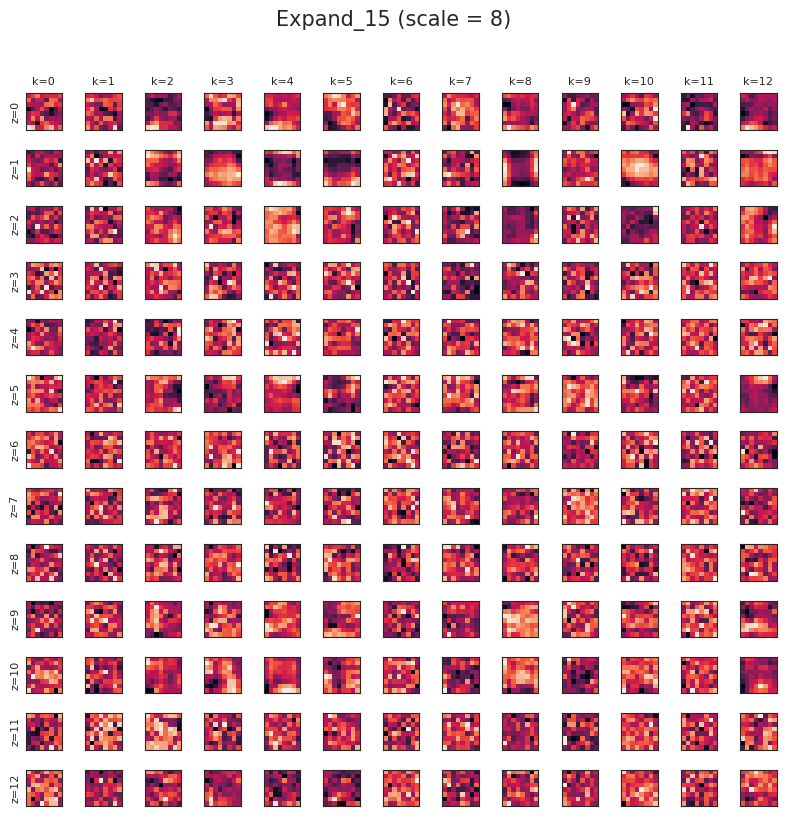

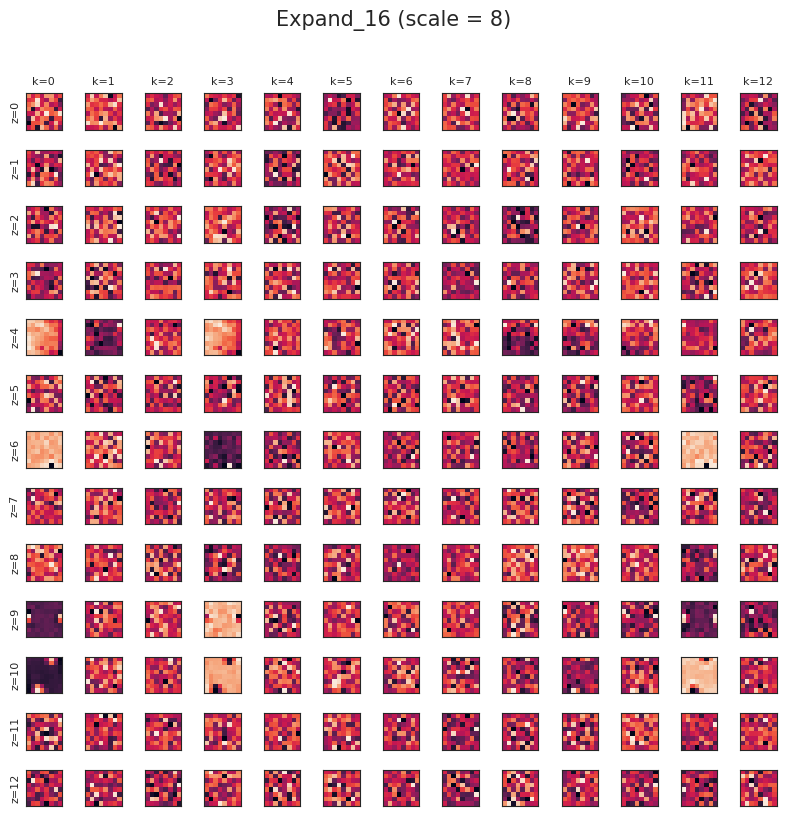

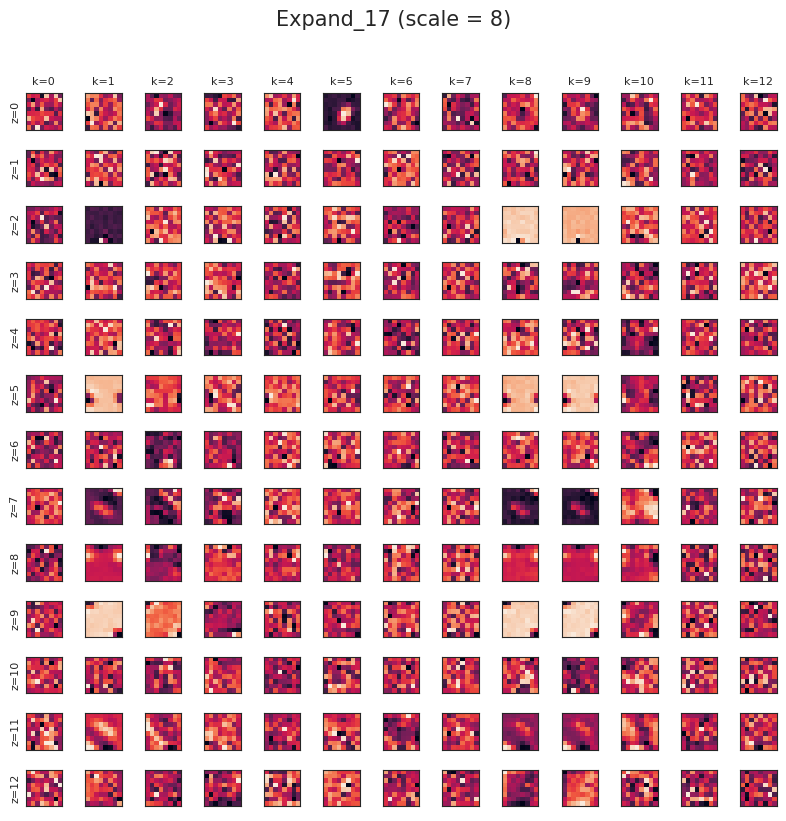

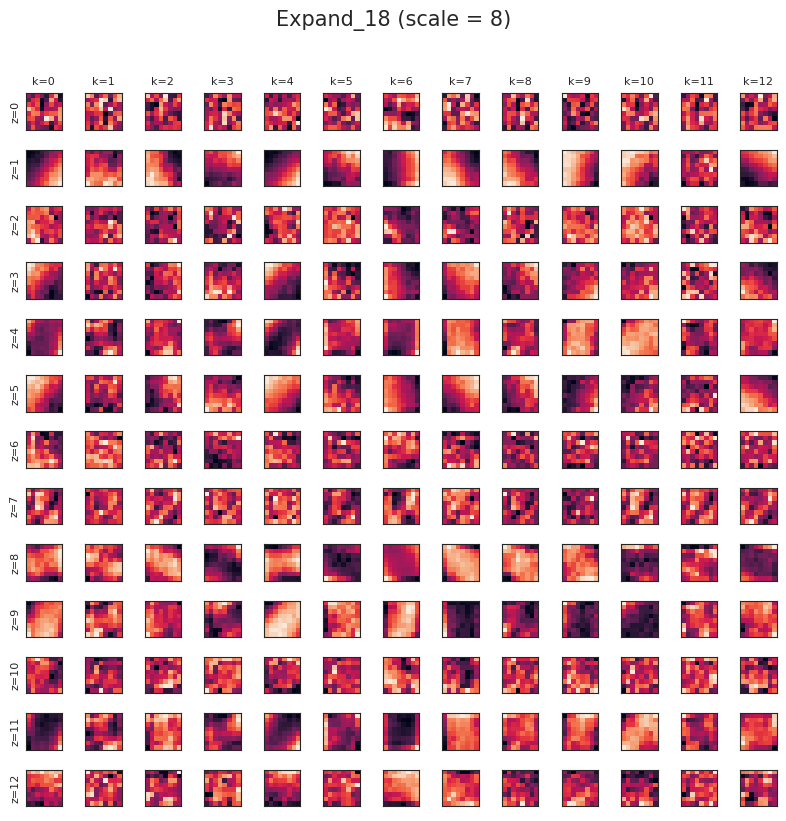

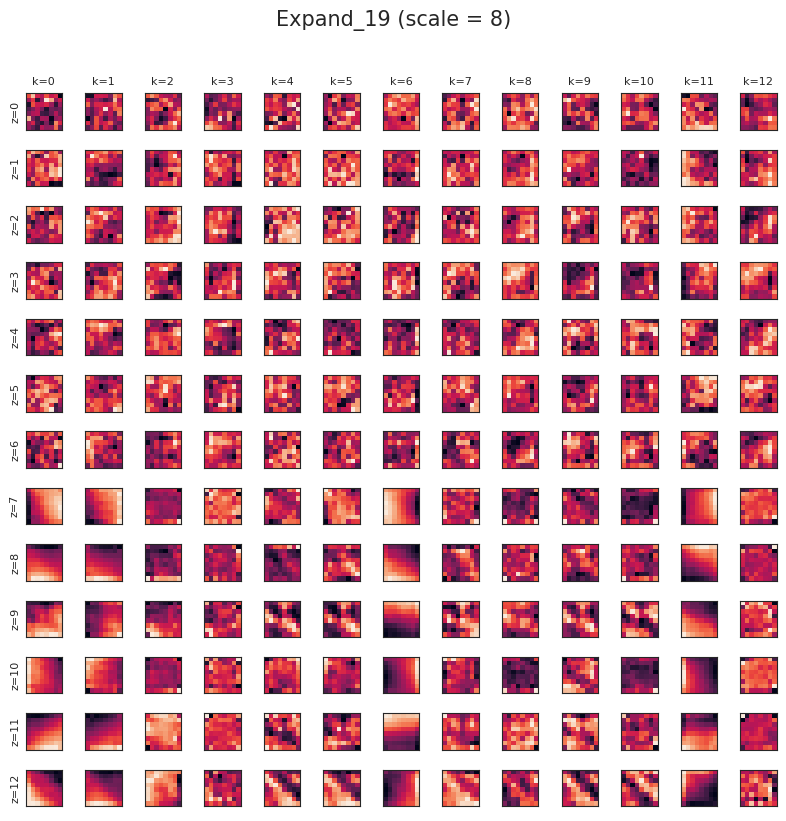

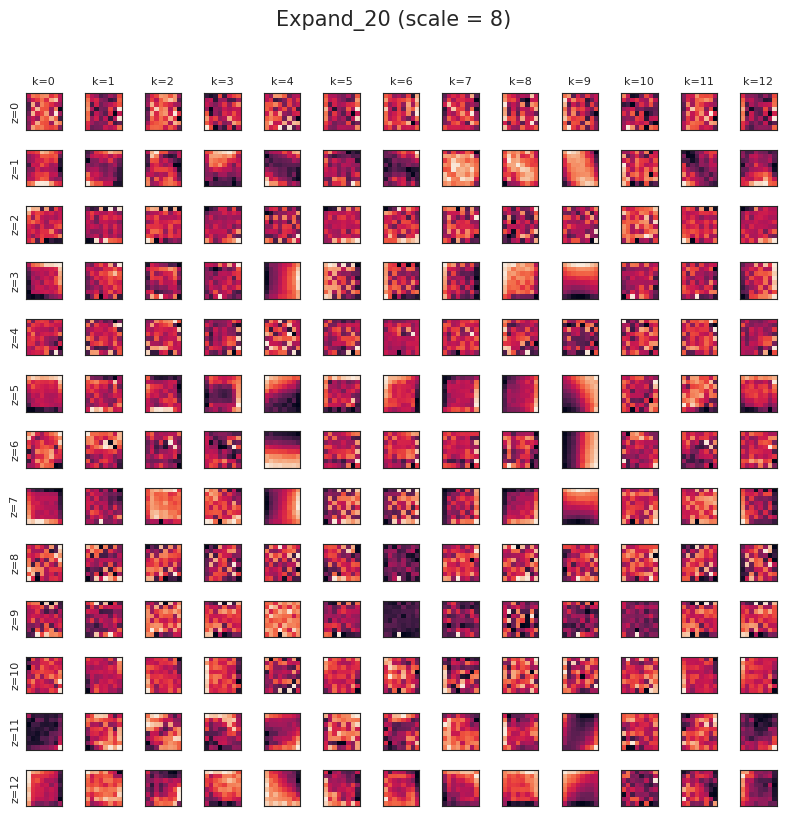

CPU times: user 5min 40s, sys: 280 ms, total: 5min 40s
Wall time: 5min 40s


In [73]:
%%time

scales, _ = tr.model.latent_scales()
num = vae.cfg.n_latent_per_group

for i, m in enumerate(vae.expand):
    _w = to_np(m.weight)
    fig, axes = create_figure(num, num, (8, 8), 'all', 'all', tight_layout=True)
    for z, k in itertools.product(range(num), range(num)):
        ax = axes[z, k]
        ax.imshow(_w[z, k])
        if z == 0:
            ax.set_title(f"k={k}", fontsize=8)
        if k == 0:
            ax.set_ylabel(f"z={z}", fontsize=8)
    fig.suptitle(f'Expand_{i} (scale = {scales[i]})', fontsize=15, y=1.02)
    remove_ticks(axes, False)
    plt.show()

In [81]:
for i, m in enumerate(vae.expand):
    norm = m.lognorm.exp().detach()
    print({i: norm.mean().item()}, norm)

{0: 1.0124108791351318}
tensor([1.0176, 0.9984, 1.0072, 1.0124, 1.0103, 1.0173, 1.0221, 1.0197, 1.0179,
        0.9977, 1.0204, 0.9998, 1.0206], device='cuda:0')

{1: 0.9178216457366943}
tensor([0.8444, 0.9364, 0.8861, 0.9927, 0.9025, 0.8532, 0.8757, 0.8678, 0.9957,
        0.9946, 0.8517, 0.9341, 0.9966], device='cuda:0')

{2: 0.9390156269073486}
tensor([0.8422, 0.9937, 0.9936, 0.8136, 0.9194, 0.9941, 0.9947, 0.9604, 1.0029,
        0.9207, 0.9083, 0.9741, 0.8896], device='cuda:0')

{3: 0.9607516527175903}
tensor([0.9625, 0.9630, 0.9633, 0.9649, 0.9635, 0.9634, 0.9617, 0.9536, 0.9590,
        0.9585, 0.9626, 0.9592, 0.9545], device='cuda:0')

{4: 0.935439944267273}
tensor([0.9400, 0.9372, 1.0790, 0.9068, 0.9461, 0.9345, 0.9337, 0.9166, 0.9369,
        0.9224, 0.8212, 0.9307, 0.9556], device='cuda:0')

{5: 0.8846462368965149}
tensor([0.8616, 0.8747, 0.8896, 0.8675, 0.8986, 0.8772, 0.8877, 0.8971, 0.9168,
        0.8897, 0.8877, 0.8624, 0.8898], device='cuda:0')

{6: 0.896066427230835}
tensor([0.9218, 0.8812, 0.9079, 0.9085, 0.8966, 0.9212, 0.8987, 0.9187, 0.9011,
        0.8908, 0.7855, 0.9001, 0.9166], device='cuda:0')

{7: 0.9073945879936218}
tensor([0.8552, 0.9767, 0.7339, 0.9748, 0.9753, 0.9737, 0.9202, 0.9812, 0.9762,
        0.8462, 0.8022, 0.9673, 0.8131], device='cuda:0')

{8: 0.8717076778411865}
tensor([0.9387, 0.9445, 0.9354, 0.6818, 0.9379, 0.9407, 0.6324, 0.9421, 0.9415,
        0.9412, 0.9457, 0.6104, 0.9399], device='cuda:0')

{9: 0.8970179557800293}
tensor([0.8948, 0.8714, 0.8805, 0.8853, 0.8902, 0.8885, 1.0130, 0.8837, 0.8860,
        0.8922, 0.8916, 0.8934, 0.8907], device='cuda:0')

{10: 0.9240987300872803}
tensor([0.9224, 0.8949, 0.8920, 1.2374, 0.8908, 0.8839, 0.8972, 0.8900, 0.8993,
        0.8934, 0.9010, 0.9059, 0.9053], device='cuda:0')

{11: 1.0245001316070557}
tensor([0.9643, 0.9660, 0.9593, 0.9625, 0.9568, 0.9693, 0.9686, 1.7640, 0.9605,
        0.9559, 0.9767, 0.9519, 0.9628], device='cuda:0')

{12: 0.8951259255409241}
tensor([0.8540, 0.9070, 0.9112, 0.9223, 0.8688, 0.8329, 0.8431, 0.9189, 0.9181,
        0.8035, 0.9145, 1.0776, 0.8647], device='cuda:0')

{13: 0.9438376426696777}
tensor([0.9391, 0.9463, 0.9426, 0.9197, 0.9247, 0.9258, 0.9312, 0.9299, 0.9308,
        0.9309, 0.9389, 1.0783, 0.9318], device='cuda:0')

{14: 0.9741033315658569}
tensor([0.9059, 0.9790, 0.8987, 0.9792, 0.9810, 0.9723, 0.9781, 0.8920, 0.9792,
        0.9776, 0.9777, 1.1664, 0.9761], device='cuda:0')

{15: 0.9738444089889526}
tensor([0.9877, 0.9897, 0.8719, 0.8697, 1.0779, 0.8298, 0.9948, 0.9879, 1.0881,
        0.9898, 1.0620, 0.9909, 0.9199], device='cuda:0')

{16: 0.9870063066482544}
tensor([0.9470, 0.9857, 0.9822, 1.1290, 0.9865, 0.9810, 0.9824, 0.9803, 0.9779,
        0.9801, 0.9740, 0.9433, 0.9817], device='cuda:0')

{17: 1.0500739812850952}
tensor([0.9906, 1.4140, 0.9378, 0.9717, 0.9852, 1.2447, 0.9868, 0.9905, 1.1810,
        1.0522, 0.9227, 0.9879, 0.9857], device='cuda:0')

{18: 1.0333240032196045}
tensor([1.0836, 1.2622, 0.9328, 0.9707, 1.0938, 1.0092, 0.9997, 0.9807, 1.0376,
        1.0141, 0.9882, 1.0738, 0.9869], device='cuda:0')

{19: 0.9529003500938416}
tensor([0.8785, 0.8771, 0.9166, 0.9889, 1.1288, 0.9280, 0.9189, 0.8508, 0.9570,
        1.1514, 0.9348, 0.8708, 0.9860], device='cuda:0')

{20: 0.8749111890792847}
tensor([0.8331, 0.9205, 0.9063, 0.8987, 0.7384, 0.9478, 0.9425, 0.8818, 0.7949,
        0.7345, 0.9482, 0.8878, 0.9392], device='cuda:0')